<a href="https://colab.research.google.com/github/Bambukabir/Bambutryings/blob/main/batik_project_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batik Classification Project
This notebook is cleaned and reordered so it can be run **top-to-bottom without errors**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


## Dataset Loading and Inspection

In [6]:
dataset_path = '/content/drive/MyDrive/batik_dataset'
print(os.path.exists(dataset_path))
print(os.listdir(dataset_path))

True
['batik-bali', 'batik-celup', 'batik-betawi', 'batik-ceplok', 'batik-cendrawasih', 'batik-garutan', 'batik-ciamis', 'batik-gentongan', 'batik-kawung', 'batik-keraton', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-pekalongan', 'batik-priangan', 'batik-sidoluhur', 'batik-sekar', 'batik-sogan', 'batik-sidomukti', 'batik-tambal']


In [7]:
class_names = sorted(os.listdir(dataset_path))
print('Classes:', class_names)
print('Total classes:', len(class_names))

Classes: ['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih', 'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan', 'batik-kawung', 'batik-keraton', 'batik-lasem', 'batik-megamendung', 'batik-parang', 'batik-pekalongan', 'batik-priangan', 'batik-sekar', 'batik-sidoluhur', 'batik-sidomukti', 'batik-sogan', 'batik-tambal']
Total classes: 20


In [8]:
for cls in class_names:
    cls_path = os.path.join(dataset_path, cls)
    print(cls, '->', len(os.listdir(cls_path)))

batik-bali -> 50
batik-betawi -> 50
batik-celup -> 50
batik-cendrawasih -> 50
batik-ceplok -> 48
batik-ciamis -> 50
batik-garutan -> 50
batik-gentongan -> 50
batik-kawung -> 45
batik-keraton -> 50
batik-lasem -> 50
batik-megamendung -> 47
batik-parang -> 50
batik-pekalongan -> 50
batik-priangan -> 50
batik-sekar -> 47
batik-sidoluhur -> 50
batik-sidomukti -> 46
batik-sogan -> 50
batik-tambal -> 50


## LOADING IMAGES WITH CANNY EDGE


In [49]:
IMG_SIZE = 224
X, y = [], []

print("="*60)
print("LOADING IMAGES WITH CANNY EDGE ")
print("="*60)

for idx, cls in enumerate(class_names):
    cls_path = os.path.join(dataset_path, cls)

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue

        # 1. Resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # 2. Convert to grayscale for Canny
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 3. Apply Canny Edge Detector
        edges = cv2.Canny(gray, 100, 200)

        # 4. Convert edges to 3 channels
        edges_rgb = np.stack([edges]*3, axis=-1)

        # 5. Fuse original image with edges
        fused_img = cv2.addWeighted(img, 0.7, edges_rgb, 0.3, 0)

        # 6. Normalize
        fused_img = fused_img / 255.0

        X.append(fused_img)
        y.append(idx)

X = np.array(X)
y = np.array(y)

print("Dataset loaded successfully")
print("Image shape:", X.shape)
print("Labels shape:", y.shape)


LOADING IMAGES WITH CANNY EDGE 
Dataset loaded successfully
Image shape: (981, 224, 224, 3)
Labels shape: (981,)


#CANNY EDGE DETECTOR VISUALIZATION (BATIK SAMPLE)


CANNY EDGE DETECTOR VISUALIZATION (BATIK SAMPLE)


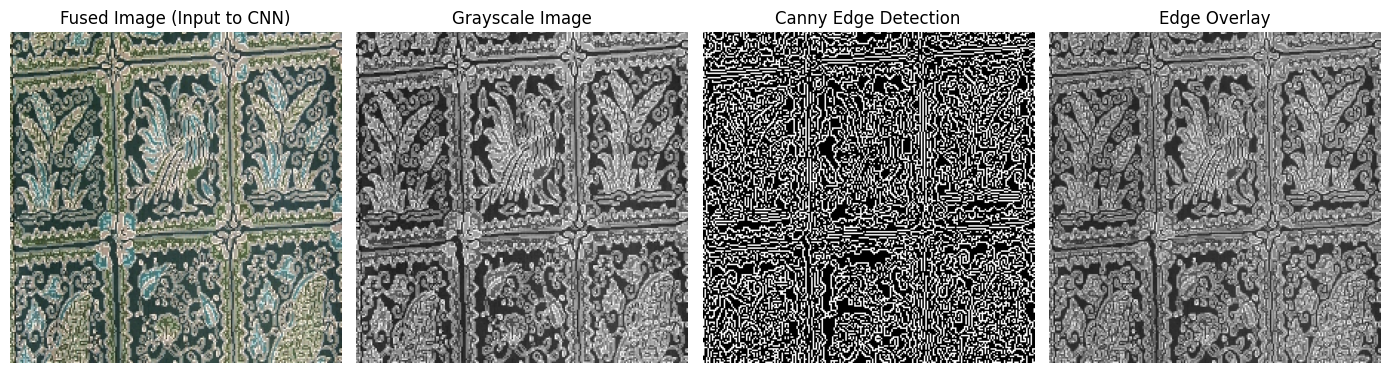

In [52]:
import random
import matplotlib.pyplot as plt
import cv2

print("="*60)
print("CANNY EDGE DETECTOR VISUALIZATION (BATIK SAMPLE)")
print("="*60)

idx = random.randint(0, len(X) - 1)

fused_img = (X[idx] * 255).astype("uint8")
gray_img = cv2.cvtColor(fused_img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, 100, 200)

plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.title("Fused Image (Input to CNN)")
plt.imshow(cv2.cvtColor(fused_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Grayscale Image")
plt.imshow(gray_img, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Edge Overlay")
overlay = cv2.addWeighted(
    cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR),
    0.8,
    cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR),
    0.2,
    0
)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


#DATA AUGMENTATION

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


## Train / Validation Split

In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_val.shape)

(784, 224, 224, 3) (197, 224, 224, 3)


In [55]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.98), 1: np.float64(0.98), 2: np.float64(0.98), 3: np.float64(1.005128205128205), 4: np.float64(1.0315789473684212), 5: np.float64(0.98), 6: np.float64(0.98), 7: np.float64(0.98), 8: np.float64(1.0888888888888888), 9: np.float64(0.98), 10: np.float64(0.98), 11: np.float64(1.0594594594594595), 12: np.float64(0.98), 13: np.float64(0.98), 14: np.float64(0.98), 15: np.float64(1.0594594594594595), 16: np.float64(0.98), 17: np.float64(1.0594594594594595), 18: np.float64(0.98), 19: np.float64(0.98)}


## Model Building

In [56]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,283,604 (8.71 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#MODEL FINE-TUNING

In [57]:
for layer in base_model.layers[-40:]:
    layer.trainable = True


#Recompile with low LR

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## TRAINING

In [39]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.0517 - loss: 3.3059 - val_accuracy: 0.0609 - val_loss: 3.2299
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.0688 - loss: 3.0984 - val_accuracy: 0.0660 - val_loss: 3.1230
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1042 - loss: 2.9280 - val_accuracy: 0.0863 - val_loss: 3.0479
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1065 - loss: 2.8480 - val_accuracy: 0.1168 - val_loss: 2.9865
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1259 - loss: 2.7407 - val_accuracy: 0.1320 - val_loss: 2.9274
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1956 - loss: 2.6474 - val_accuracy: 0.1523 - val_loss: 2.8789
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2017 - loss: 2.5725 - val_accuracy: 0.1675 - val_loss: 2.8334
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2341 - loss: 2.4746 - val_accuracy: 0.1726 -

#EARLY STOPPING

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


#MODEL TRAINING (70 EPOCHS)

In [61]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=70,
    callbacks=[early_stop]
)


Epoch 1/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.1060 - loss: 3.0036 - val_accuracy: 0.0508 - val_loss: 3.3407
Epoch 2/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.1233 - loss: 2.9659 - val_accuracy: 0.0609 - val_loss: 3.2886
Epoch 3/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.1770 - loss: 2.8062 - val_accuracy: 0.0711 - val_loss: 3.2446
Epoch 4/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2110 - loss: 2.7544 - val_accuracy: 0.1015 - val_loss: 3.2021
Epoch 5/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.2283 - loss: 2.6824 - val_accuracy: 0.1066 - val_loss: 3.1587
Epoch 6/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.2584 - loss: 2.5886 - val_accuracy: 0.1269 - val_loss: 3.1185
Epoch 7/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.2882 - loss: 2.4745 - val_accuracy: 0.1523 - val_loss: 3.0839
Epoch 8/70
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.2994 - loss: 2.4498 - val_accur

# EVALUATION: ACCURACY




In [62]:
print("="*60)
print("EVALUATION: MODEL ACCURACY")
print("="*60)

loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy : {accuracy * 100:.2f}%")
print(f"Validation Loss     : {loss:.4f}")


EVALUATION: MODEL ACCURACY
Validation Accuracy : 36.55%
Validation Loss     : 2.2680


#Generate Predictions

In [63]:
print("\n" + "="*60)
print("EVALUATION: PREDICTION RESULTS")
print("="*60)

y_prob = model.predict(X_val)
y_pred = np.argmax(y_prob, axis=1)
print("Predictions generated successfully.")



EVALUATION: PREDICTION RESULTS


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 685ms/step
Predictions generated successfully.


#Confusion Matrix (Numeric)

In [68]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*60)
print("EVALUATION: CONFUSION MATRIX (NUMERIC)")
print("="*60)

cm = confusion_matrix(y_val, y_pred)
print(cm)



EVALUATION: CONFUSION MATRIX (NUMERIC)
[[6 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0]
 [0 4 0 0 2 0 0 0 1 0 0 0 0 0 2 0 0 1 0 0]
 [1 1 6 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 1 2 0 0 0 0 0 1 1 0 0 1 0 0 2 0 1]
 [1 0 0 0 2 0 1 0 4 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 5 0 0 1 0 0 0 0 1 1 0 0 0 0 0]
 [2 0 0 0 2 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0]
 [0 0 0 1 1 0 0 3 0 1 0 1 0 1 0 0 0 2 0 0]
 [0 0 0 0 2 0 0 0 5 0 0 0 0 0 0 0 2 0 0 0]
 [3 0 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 1 1 0]
 [2 0 0 0 0 0 0 1 0 0 1 1 0 0 0 2 0 2 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0]
 [4 1 0 0 0 1 0 1 1 0 0 0 0 2 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 1 3 2 0 0 1 0]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 5 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 7 1 0 0]
 [0 0 2 0 1 0 0 2 0 1 0 0 0 0 0 0 0 0 2 1]
 [1 0 0 0 3 0 0 1 0 0 0 0 0 0 0 0 1 0 3 1]
 [0 0 0 0 2 0 1 1 0 0 0 0 0 0 1 1 0 1 0 3]]


#Confusion Matrix (Visualization)


EVALUATION: CONFUSION MATRIX (WELL-ARRANGED)


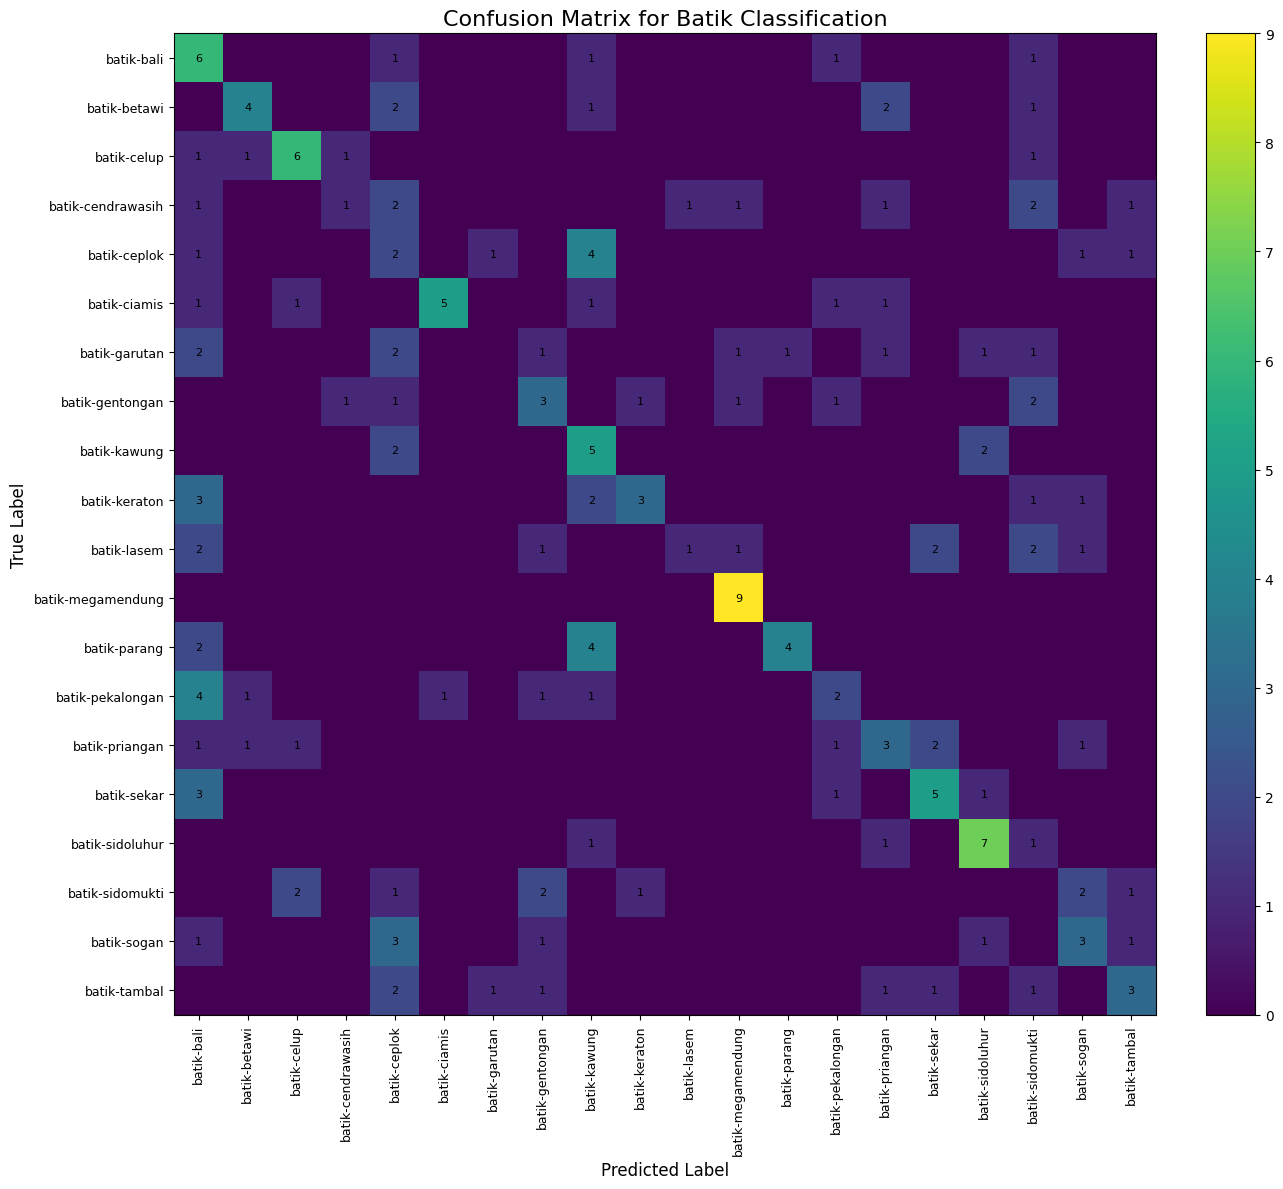

In [65]:
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("EVALUATION: CONFUSION MATRIX (WELL-ARRANGED)")
print("="*70)

plt.figure(figsize=(14, 12))  # Bigger figure for many classes
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix for Batik Classification", fontsize=16)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Proper ticks with spacing
plt.xticks(
    ticks=np.arange(len(class_names)),
    labels=class_names,
    rotation=90,
    fontsize=9
)

plt.yticks(
    ticks=np.arange(len(class_names)),
    labels=class_names,
    fontsize=9
)

# Annotate only non-zero values (cleaner)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if cm[i, j] > 0:
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                fontsize=8
            )

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


#Classification Report

In [66]:
from sklearn.metrics import classification_report

print("\n" + "="*60)
print("EVALUATION: CLASSIFICATION REPORT")
print("="*60)

print(classification_report(y_val, y_pred, target_names=class_names))



EVALUATION: CLASSIFICATION REPORT
                   precision    recall  f1-score   support

       batik-bali       0.21      0.60      0.32        10
     batik-betawi       0.57      0.40      0.47        10
      batik-celup       0.60      0.60      0.60        10
batik-cendrawasih       0.33      0.10      0.15        10
     batik-ceplok       0.11      0.20      0.14        10
     batik-ciamis       0.83      0.50      0.62        10
    batik-garutan       0.00      0.00      0.00        10
  batik-gentongan       0.30      0.30      0.30        10
     batik-kawung       0.25      0.56      0.34         9
    batik-keraton       0.60      0.30      0.40        10
      batik-lasem       0.50      0.10      0.17        10
batik-megamendung       0.69      1.00      0.82         9
     batik-parang       0.80      0.40      0.53        10
 batik-pekalongan       0.29      0.20      0.24        10
   batik-priangan       0.30      0.30      0.30        10
      batik-sekar   

#Accuracy & Loss Curves


EVALUATION: TRAINING & VALIDATION CURVES


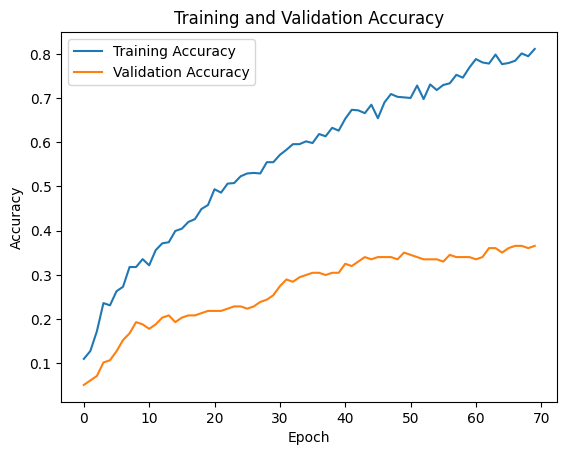

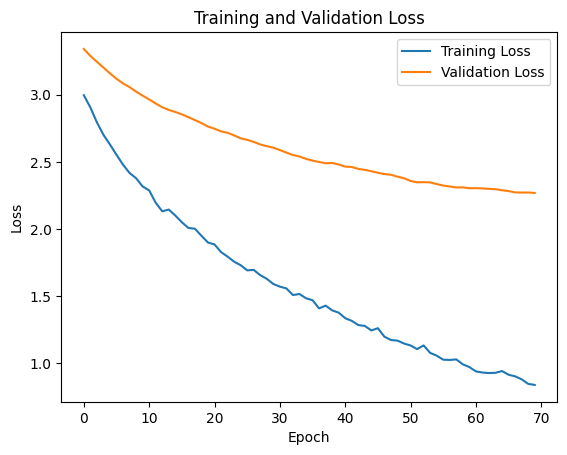

In [67]:
print("\n" + "="*60)
print("EVALUATION: TRAINING & VALIDATION CURVES")
print("="*60)

plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Saving the model

In [84]:
import os
from google.colab import drive
import numpy as np

print("="*60)
print("FINAL STEP: SAVING PROJECT ARTIFACTS TO GOOGLE DRIVE")
print("="*60)

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Project folder in Drive
project_folder = "/content/drive/MyDrive/batik_project"
os.makedirs(project_folder, exist_ok=True)

# 3. Save trained model (.keras format)
model_path = os.path.join(project_folder, "final_batik_mobilenetv2.keras")
model.save(model_path)
print(f"✅ Model saved: {model_path}")

# 4. Save class names
classes_path = os.path.join(project_folder, "class_names.npy")
np.save(classes_path, class_names)
print(f"✅ Class names saved: {classes_path}")

# 5. Save labels (ground truth)
labels_path = os.path.join(project_folder, "labels.npy")
np.save(labels_path, y)
print(f"✅ Labels saved: {labels_path}")

# 6. Save confusion matrix
cm_path = os.path.join(project_folder, "confusion_matrix.npy")
np.save(cm_path, cm)
print(f"✅ Confusion matrix saved: {cm_path}")

# 7. Save training history
history_path = os.path.join(project_folder, "training_history.npy")
np.save(history_path, history.history)
print(f"✅ Training history saved: {history_path}")

print("\n🎉 ALL PROJECT FILES SAVED SUCCESSFULLY!")


FINAL STEP: SAVING PROJECT ARTIFACTS TO GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved: /content/drive/MyDrive/batik_project/final_batik_mobilenetv2.keras
✅ Class names saved: /content/drive/MyDrive/batik_project/class_names.npy
✅ Labels saved: /content/drive/MyDrive/batik_project/labels.npy
✅ Confusion matrix saved: /content/drive/MyDrive/batik_project/confusion_matrix.npy
✅ Training history saved: /content/drive/MyDrive/batik_project/training_history.npy

🎉 ALL PROJECT FILES SAVED SUCCESSFULLY!


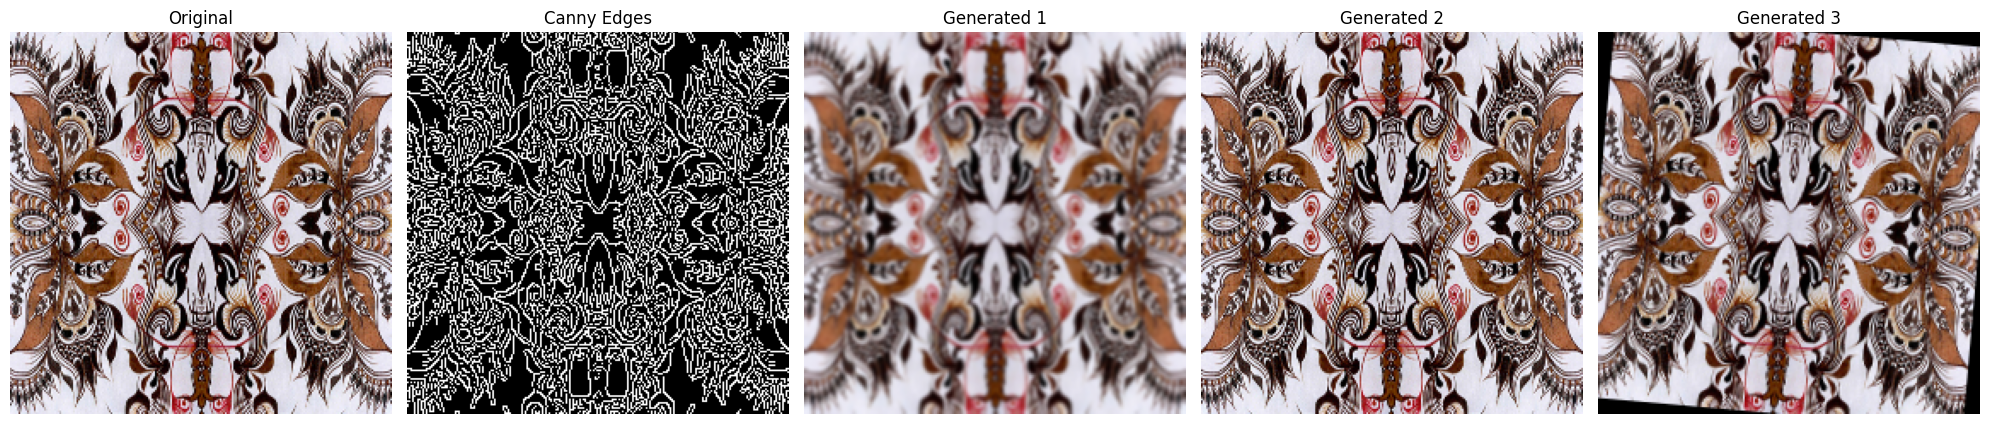

In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Step 1: Load original Batik image ---
image_path = "/content/drive/MyDrive/batik_dataset /batik-bali/22.jpg"
img = cv2.imread(image_path)
if img is None:
    raise ValueError("Image not found. Check the path carefully.")

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))

# --- Step 2: Apply Canny Edge Detection ---
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(img_gray, threshold1=100, threshold2=200)

# --- Step 3: Generate dummy “generated motifs” ---
# For demonstration, we use simple transformations
generated_samples = []
# Gaussian Blur
generated_samples.append(cv2.GaussianBlur(img_resized, (5,5), 0))
# Horizontal flip
generated_samples.append(cv2.flip(img_resized, 1))
# Random rotation
angle = random.randint(-30, 30)
(h, w) = img_resized.shape[:2]
M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
generated_samples.append(cv2.warpAffine(img_resized, M, (w, h)))

# --- Step 4: Display Original + Edges + Generated Samples ---
fig, axes = plt.subplots(1, 5, figsize=(20,5))

# Original
axes[0].imshow(img_resized)
axes[0].set_title("Original")
axes[0].axis("off")

# Edges
axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Canny Edges")
axes[1].axis("off")

# Generated Samples
for i in range(3):
    axes[i+2].imshow(generated_samples[i])
    axes[i+2].set_title(f"Generated {i+1}")
    axes[i+2].axis("off")

plt.tight_layout()
plt.show()


#Loading the model

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("/content/drive/MyDrive/batik_project/final_batik_mobilenetv2.keras")
class_names = np.load("/content/drive/MyDrive/batik_project/class_names.npy", allow_pickle=True)
